In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_cleaner import *
from room_energy import energyLossAllRooms, energy_to_building

In [2]:
df_fcu_sth_raw = pd.read_csv('data/Gnd floor FCU Sth 16032020.csv')
df_fcu_nth_raw = pd.read_csv('data/Gnd floor FCU North 16032020.csv')
df_ahu_raw = pd.read_csv('data/Gnd AHU multi list 16032020.csv')
df_chiller_boiler_raw = pd.read_csv('data/more_Data/chillers boilers thermal Feb 23032020.csv')
room_info_raw = pd.read_csv('data/Room Details.csv')
df_ltb_space_raw = pd.read_csv('data/LTB Space Data.csv')

In [3]:
df_ltb_temps = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw)
df_chiller_boiler_power = create_chiller_boiler_power_df(df_chiller_boiler_raw)
df_room_info = create_room_info_df(room_info_raw)

# Ignore rooms with no external walls
df_ltb_temps = df_ltb_temps.drop(['AHU-B1-02 ZnTmp_1', 'AHU-B1-02 ZnTmp_2','FCU-16 ZnTmp', 'FCU-15 ZnTmp'], axis=1)
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'AHU-B1-02']
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'FCU-16']
df_room_info = df_room_info[df_room_info['AHU / FCU'] != 'FCU-15']

In [4]:
df_energy_room_change = energyLossAllRooms(df_ltb_temps, df_room_info, time_frame=["06:00", "18:00"])
df_energy_external = energy_to_building(df_ltb_temps, df_room_info, time_frame=["06:00", "18:00"])
df_energy_air_leak = energyLossAllRooms(df_ltb_temps, df_room_info, calc_type='airLeak')

# Plotting results

#### Single Day Temperature results

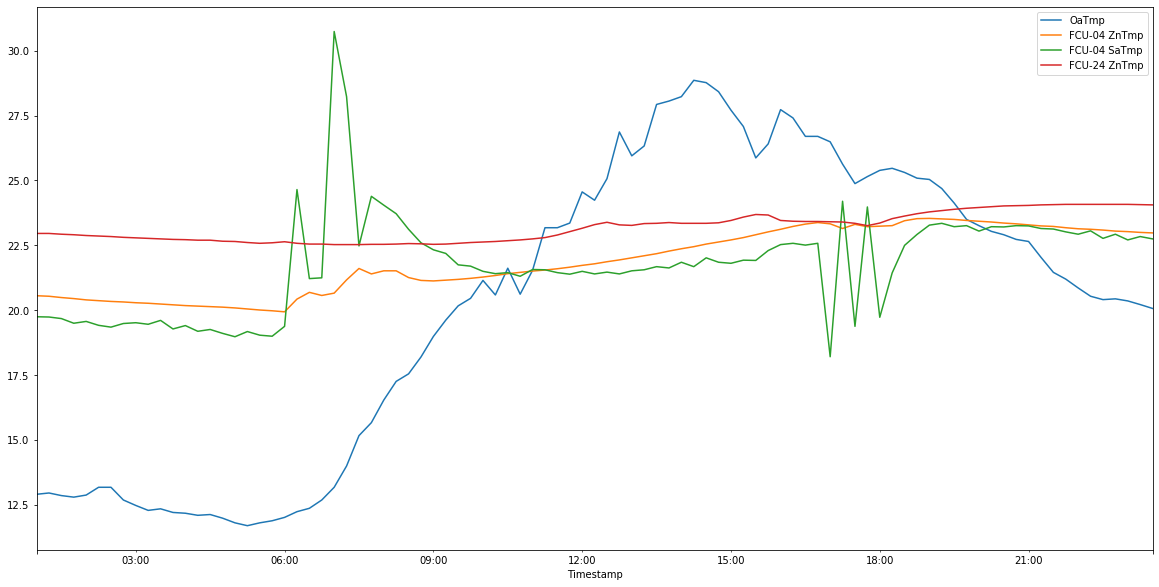

In [5]:
START_DATE = '2020-02-06 01:10:0'  
END_DATE = '2020-02-06 23:59:59'
df_ltb_temps_day = create_temp_df(df_fcu_sth_raw, df_fcu_nth_raw, df_ahu_raw, START_DATE, END_DATE)

time_frame = ["00:00", "23:30"]
zn_tmp = 'FCU-04 ZnTmp'
sa_tmp = 'FCU-04 SaTmp'
df_ltb_temps_day = df_ltb_temps_day.between_time(time_frame[0], time_frame[1])
delta_temp = df_ltb_temps_day['OaTmp'] - df_ltb_temps_day[zn_tmp]
 
# Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

df_ltb_temps_day['OaTmp'].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day[zn_tmp].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day[sa_tmp].plot(kind='line', ax=ax, legend=True)
df_ltb_temps_day['FCU-24 ZnTmp'].plot(kind='line', ax=ax, legend=True)


#delta_temp.plot(kind='line', ax=ax, legend=True)

plt.show()

#### Full Time Period

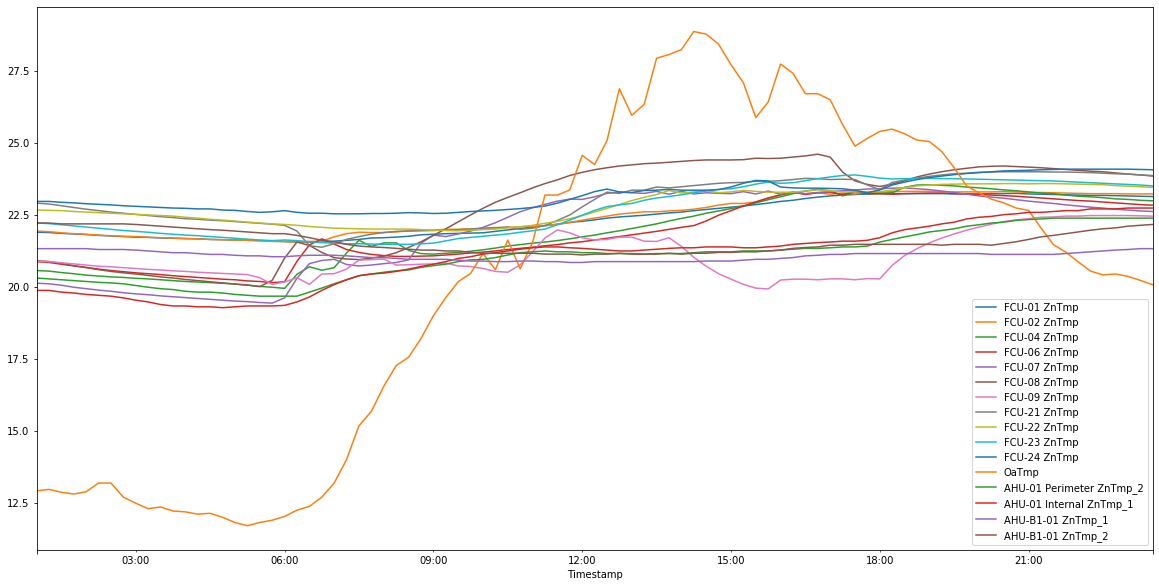

In [6]:
time_frame = ["06:00", "18:00"]
df_ltb_temps_open = df_ltb_temps.between_time(time_frame[0], time_frame[1])
 
# Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()

for col in df_ltb_temps_open.columns:
    if 'Sa' not in col and 'OaRH' not in col:
        df_ltb_temps_day[col].plot(kind='line', ax=ax, legend=True)

plt.show()

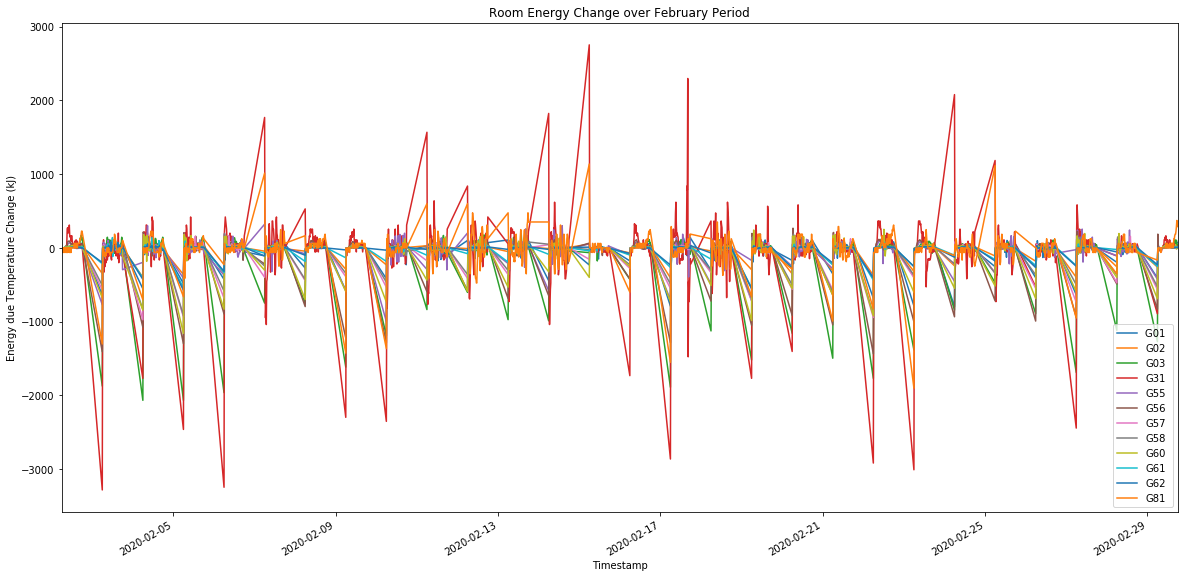

In [7]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Room Energy Change over February Period")
ax.set_ylabel("Energy due Temperature Change (kJ)")
for col in df_energy_room_change.columns:
    df_energy_room_change[col].plot(kind='line', ax=ax, legend=True)

plt.legend(loc="lower right")
plt.show()

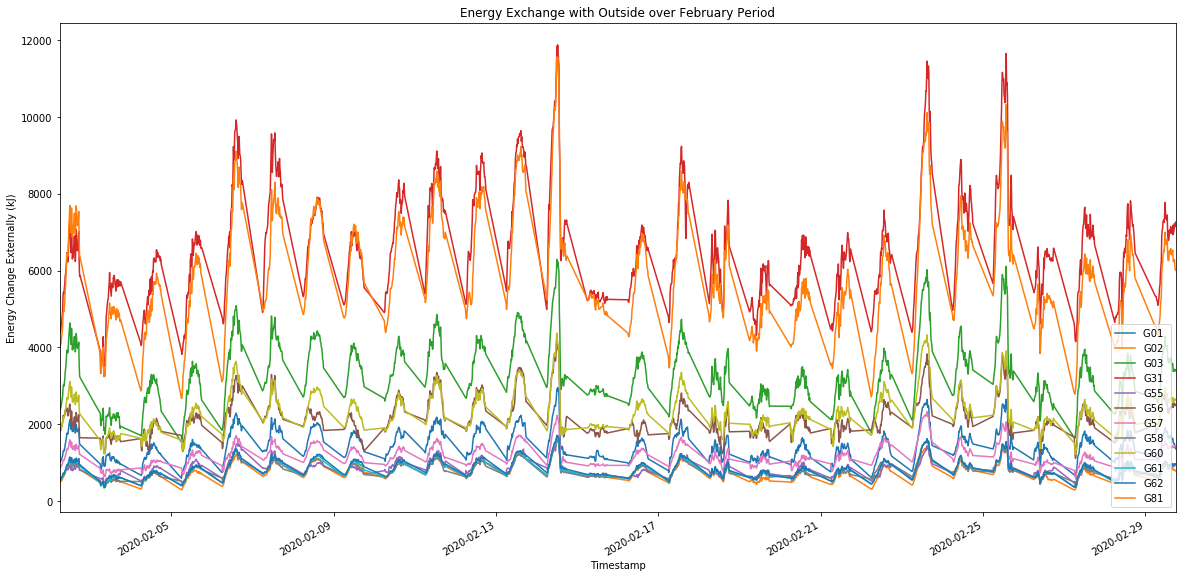

In [8]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Energy Exchange with Outside over February Period")
ax.set_ylabel("Energy Change Externally (kJ)")
for col in df_energy_external.columns:
    df_energy_external[col].plot(kind='line', ax=ax, legend=True)
    
plt.legend(loc="lower right")
plt.show()

Assuming change in room energy = incoming energy from outside - reduction of energy from AC

-> reduction of energy from AC = incoming - change in room 

In [9]:
df_effectice_ac_energy = df_energy_external - df_energy_room_change
df_effectice_ac_energy.iloc[1:3]

,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,1024.595201,497.065297,2391.435342,4437.983073,587.350063,1820.038420,876.329839,574.220543,1820.000259,549.796520,565.157736,4016.576768
2020-02-02 06:30:00,1038.322837,504.350122,2422.210831,4475.872848,587.280693,1839.497561,878.009074,580.220967,1838.421721,557.530025,572.036747,4112.178123


In [10]:
df_energy_external.iloc[1:3]

,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,1018.069519,494.110733,2375.352094,4383.285637,580.715933,1813.597087,870.594763,574.220543,1820.000259,546.681960,565.157736,4016.576768
2020-02-02 06:30:00,1028.534315,498.440993,2398.085960,4421.175413,583.963628,1829.835563,875.141537,577.468238,1832.124987,551.300904,568.621944,4050.136283


In [11]:
df_energy_room_change.iloc[1:3]

,G01,G02,G03,G31,G55,G56,G57,G58,G60,G61,G62,G81
Timestamp,,,,,,,,,,,,
2020-02-02 06:15:00,-6.525682,-2.954565,-16.083248,-54.697436,-6.634131,-6.441332,-5.735075,0.000000,0.000000,-3.114560,0.000000,0.00000
2020-02-02 06:30:00,-9.788522,-5.909129,-24.124872,-54.697436,-3.317065,-9.661999,-2.867538,-2.752729,-6.296734,-6.229121,-3.414803,-62.04184


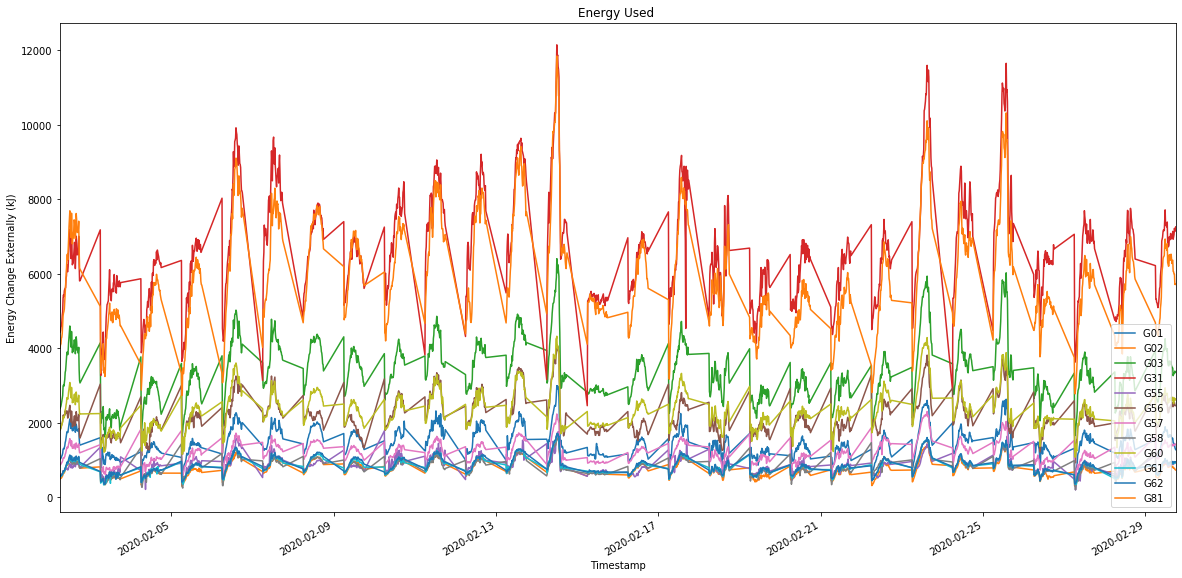

In [12]:
 # Get current axis
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("Energy Used ")
ax.set_ylabel("Energy Change Externally (kJ)")
for col in df_effectice_ac_energy.columns:
    df_effectice_ac_energy[col].plot(kind='line', ax=ax, legend=True)
    
plt.legend(loc="lower right")
plt.show()

In [13]:
ac_energy_work = df_effectice_ac_energy.abs().sum().sum()
room_energy_air_leak = df_energy_air_leak.abs().sum().sum()

In [14]:
chiller_energy, boiler_energy = get_power_used(df_chiller_boiler_power)

total_ac_energy_used = chiller_energy + boiler_energy

ac_floor_area = df_room_info['Total Area'].sum()
ltb_floor_area = df_ltb_space_raw['Room Area'].sum()
gnd_floor_area = df_ltb_space_raw[df_ltb_space_raw['Floor'] == '01']['Room Area'].sum()

ac_area_multiplier = ltb_floor_area / ac_floor_area
building_ac_energy_work = ac_area_multiplier * (ac_energy_work + room_energy_air_leak)

In [15]:
print(ac_floor_area)
print(ltb_floor_area)

2240.92
27048.93


In [16]:
BTU = building_ac_energy_work/ 1.055  # kJ to BTU
print(BTU)
total_ac_wh = total_ac_energy_used/ 3.6  # kJ to Wh
print(total_ac_wh)

434960230.49103713
97375140.0


In [17]:
SEER = BTU/total_ac_wh

In [18]:
SEER

4.466850887105653

In [19]:
df_chiller_COP_raw = pd.read_csv('data/more_Data/chillers thermal COP Feb 23032020.csv')

In [20]:
df_chiller_COP_raw.columns = [
        col.replace(' Extended Trend Log', '')
           .replace(' - Trend - Extd', '')
           .replace('-00', '')
           .replace('OaTmp_x', 'OaTmp')
           .replace('OaRH_x', 'OaRH')
            .replace('kwr ext Internal Trend Log', '')
        for col in df_chiller_COP_raw.columns
    ]

In [21]:
df_chiller_COP_raw = df_chiller_COP_raw.replace(73.65, 0)

In [22]:
time_frame=["06:00", "18:00"]
df_chiller_COP_raw['Timestamp'] = pd.to_datetime(df_chiller_COP_raw['Timestamp'], dayfirst=True)
df_chiller_COP = df_chiller_COP_raw.resample('H', on='Timestamp').first()
df_chiller_COP_sampled = df_chiller_COP.between_time(time_frame[0], time_frame[1])

In [23]:
pd.set_option('display.max_rows', df_chiller_COP_sampled.shape[0]+1)
print(df_chiller_COP_sampled)

                              Timestamp  Cooling Capacity #3 KWr  COP #3  \
Timestamp                                                                  
2020-03-06 07:00:00 2020-03-06 07:45:00                     0.00    0.00   
2020-03-06 08:00:00 2020-03-06 08:00:00                     0.00    0.00   
2020-03-06 09:00:00 2020-03-06 09:00:00                     0.00    0.00   
2020-03-06 10:00:00 2020-03-06 10:00:00                     0.00    0.00   
2020-03-06 11:00:00 2020-03-06 11:00:00                     0.00    0.00   
2020-03-06 12:00:00 2020-03-06 12:00:00                     0.00    0.00   
2020-03-06 13:00:00 2020-03-06 13:00:00                     0.00    0.00   
2020-03-06 14:00:00 2020-03-06 14:00:00                     0.00    0.00   
2020-03-06 15:00:00 2020-03-06 15:00:00                     0.00    0.00   
2020-03-06 16:00:00 2020-03-06 16:00:00                     0.00    0.00   
2020-03-06 17:00:00 2020-03-06 17:00:00                     0.00    0.00   
2020-03-06 1

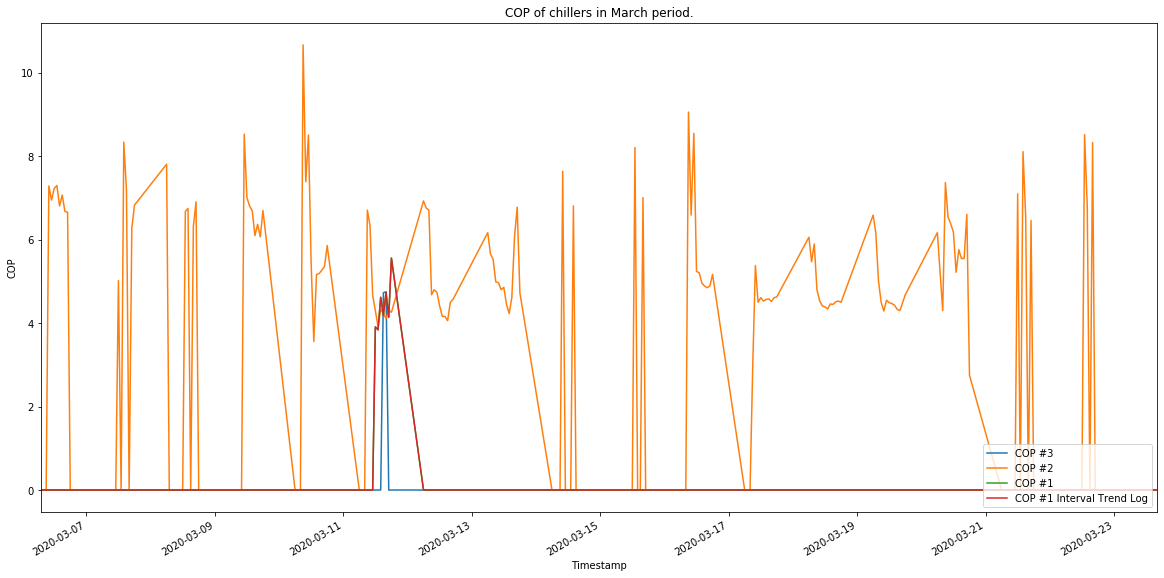

In [24]:
fig= plt.figure(figsize=(20,10))
ax = plt.gca()
ax.set_title("COP of chillers in March period.")
ax.set_ylabel("COP")
for col in df_chiller_COP_sampled.columns:
    if col.startswith('COP'):
        df_chiller_COP_sampled[col].plot(kind='line', ax=ax, legend=True)
plt.legend(loc="lower right")
plt.show()

In [25]:
chiller = 0
df_chiller_COP_sampled_mean = df_chiller_COP_sampled.replace(0, np.NaN)
for column in df_chiller_COP_sampled_mean:
    if column.startswith('COP'):
        print(column)
        chiller += df_chiller_COP_sampled_mean[column].mean()

COP #3
COP #2
COP #1 
COP #1 Interval Trend Log


In [26]:
chiller

19.267213279678067

In [27]:
df_chiller_COP_sampled = df_chiller_COP_sampled.drop(columns=['Timestamp'])